In [1]:
meas = "RNA"
layer = "raw"
census = "2024-07-01"
tissue = "heart"
var_filter = None
dask_chunk_size = 100_000
n_workers = 4
threads_per_worker = 4
tdb_concurrency = 4
mem_total_budget = 2 * 2**30
dashboard_port = 8787
hvg_inplace = True
hvg_subset = False

In [2]:
from concurrent.futures import ThreadPoolExecutor

import scanpy as sc
from somacore import AxisQuery

from tiledbsoma import Experiment, SOMATileDBContext
from tiledbsoma._dask import DaskConfig

tiledb_config = {
    "vfs.s3.no_sign_request": "true",
    "vfs.s3.region": "us-west-2",
    "sm.mem.total_budget": mem_total_budget,
    "sm.io_concurrency_level": tdb_concurrency,
    "sm.compute_concurrency_level": tdb_concurrency,
}
CENSUS_S3 = "s3://cellxgene-census-public-us-west-2/cell-census"

species = "homo_sapiens"
soma_uri = f"{CENSUS_S3}/{census}/soma"
exp_uri = f"{soma_uri}/census_data/{species}"

exp = Experiment.open(
    exp_uri,
    context=SOMATileDBContext(
        tiledb_config=tiledb_config,
        threadpool=ThreadPoolExecutor(max_workers=tdb_concurrency),
    ),
)
exp

<Experiment 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/census_data/homo_sapiens' (open for 'r') (2 items)
    'ms': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/census_data/homo_sapiens/ms' (unopened)
    'obs': 's3://cellxgene-census-public-us-west-2/cell-census/2024-07-01/soma/census_data/homo_sapiens/obs' (unopened)>

In [3]:
%%time
obs_filter = "is_primary_data == True"
if tissue:
    obs_filter = f'tissue_general == "{tissue}" and {obs_filter}'
query = exp.axis_query(
    measurement_name=meas,
    obs_query=AxisQuery(value_filter=obs_filter) if obs_filter else None,
    var_query=AxisQuery(value_filter=var_filter) if var_filter else None,
)

CPU times: user 14.9 ms, sys: 950 μs, total: 15.8 ms
Wall time: 151 ms


In [4]:
%%time
query.n_obs

CPU times: user 270 ms, sys: 520 ms, total: 790 ms
Wall time: 925 ms


1559974

In [5]:
from dask.distributed import Client, LocalCluster

if dask_chunk_size:
    cluster = LocalCluster(
        n_workers=n_workers,
        threads_per_worker=threads_per_worker,
        dashboard_address=f":{dashboard_port}",
    )
    print(f"{n_workers=}, {threads_per_worker=}, {tdb_concurrency=}")
    client = Client(cluster)
else:
    dask_chunk_size = None
    client = None
client

n_workers=4, threads_per_worker=4, tdb_concurrency=4


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 246.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45015,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 246.55 GiB
Comm: tcp://127.0.0.1:34811,Total threads: 4
Dashboard: http://127.0.0.1:32949/status,Memory: 61.64 GiB
Nanny: tcp://127.0.0.1:41507,


## HVG

In [6]:
%%time
add = query.to_anndata(
    layer,
    dask=DaskConfig(
        chunk_size=dask_chunk_size,
        tdb_concurrency=tdb_concurrency,
        tdb_configs=tiledb_config,
    ),
)
add

CPU times: user 2.17 s, sys: 1.54 s, total: 3.7 s
Wall time: 6.2 s


AnnData object with n_obs × n_vars = 1559974 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [7]:
add.X

dask.array<sparse_chunk, shape=(1559974, 60530), dtype=float32, chunksize=(100000, 60530), chunktype=scipy.csr_matrix>

In [8]:
%%time
sc.pp.normalize_total(add)

CPU times: user 169 ms, sys: 44.4 ms, total: 214 ms
Wall time: 206 ms


In [9]:
%%time
sc.pp.log1p(add)

CPU times: user 2.57 ms, sys: 0 ns, total: 2.57 ms
Wall time: 2.59 ms


In [10]:
%%time
hvg = sc.pp.highly_variable_genes(add, inplace=hvg_inplace, subset=hvg_subset)
hvg

CPU times: user 6.49 s, sys: 962 ms, total: 7.45 s
Wall time: 29.6 s


In [11]:
%%time
sc.pp.pca(add)

CPU times: user 32.9 s, sys: 1.84 s, total: 34.7 s
Wall time: 43.9 s


In [12]:
%%time
add.obsm["X_pca"] = add.obsm["X_pca"].compute()

CPU times: user 8.81 s, sys: 1.15 s, total: 9.97 s
Wall time: 18 s


In [13]:
t10 = add.obs.cell_type.value_counts().iloc[:10]
a10 = add[add.obs.cell_type.isin(t10.index)]
a10

View of AnnData object with n_obs × n_vars = 1203873 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

/home/ubuntu/.pyenv/versions/3.12.6/lib/python3.12/site-packages/anndata/_core/anndata.py:1146: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


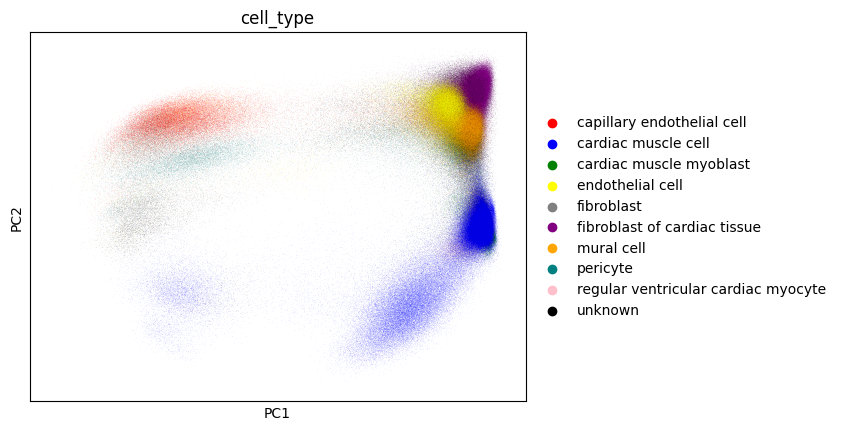

CPU times: user 16.7 s, sys: 804 ms, total: 17.5 s
Wall time: 17.2 s


In [14]:
%%time
sc.pl.pca(a10, color="cell_type", palette=["red", "blue", "green", "yellow", "grey", "purple", "orange", "teal", "pink", "black"])